# MADX file for PIMMS with PTC for tracking

In [1]:
#First importing cpymad
from cpymad.madx import Madx
madx = Madx()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.07.00  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2021.05.03               +
  + Execution date: 2024.04.25 09:50:44      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [2]:
#Importing other functions
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

/home/rlt5118/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


If you want to see every command within cpymad:`dir(madx)` </p>
Anything which isn't directly defined here can be achieved using the madx.input command.

### First need to identify the sequence and define the beam

In [3]:
#The madx.input command is your fundamental function, and directly incorporates any madx code.
#Can either define the string beforehand and input it, such as Title below. Or input directly, as shown with BEAM
Title = 'TITLE,s= "PIMMS Extraction - 09/03/2021 - R.Taylor";'
madx.input(Title)

#The call command incorporates any text file into madx
#PIMM.seq is the PIMMS sequence without the resonant sextupole
madx.call('PIMM.seq')
madx.call('betatron.str')

#Defining a carbon beam
madx.input('''BEAM, PARTICLE=  12C 6+,  MASS=11.17467, CHARGE=6, PC=1.64204774595625, ex=1, ey=1, DELTAP=0.001;
USE, PERIOD=PIMMS;''')

QF1: QUADRUPOLE, L=2*0.175, K1:= QF1k1;

QD:  QUADRUPOLE, L=2*0.175, K1:= QD1k1;

QF2: QUADRUPOLE, L=2*0.175, K1:= QF2k1;

QA : QUADRUPOLE, L=0.556,   K1:= QA1k1;



MB:  SBEND, L=1.661, ANGLE=-0.3926990817, E1=-0.19634954085, E2=-0.19634954085;



XCd1: SEXTUPOLE, L=0.2, K2:=k2xcd;

XCf1: SEXTUPOLE, L=0.2, K2:=k2xcf;

XCd2: SEXTUPOLE, L=0.2, K2:=k2xcd;

XCf2: SEXTUPOLE, L=0.2, K2:=k2xcf;

XRr : SEXTUPOLE, L=0.2, K2:=k2xrr;



ES_injection: marker;

ES_marker: marker;

MS_marker: marker;

BETkick: marker;

RFKOkick: marker;

PIMMS_START: marker;



ES_KICK = 0;

MS_KICK = 0;

ES: HKICKER, L=4*0.2   , KICK:= ES_KICK;

MS: HKICKER, L=4*0.1625, KICK:= MS_KICK;



PIMMS_cavity: RFCAVITY, L:= 0.0001, VOLT:= 0, HARMON = 1, LAG:= 0.0, no_cavity_totalpath;



PIMMS:SEQUENCE,REFER=centre,L=75.24;

              PIMMS_START, AT=0;

              PIMMS_cavity, AT=0.001;

              ES_injection, AT=1.05;

              QF1, AT=2.3875;

              MB, AT=3.8125;

              QD, AT=5.2925;

True

In [4]:
#Defines additional values of the beam
madx.input('''
  value, beam->gamma;
  value, beam->beta;
dispx:=beam->beta*table(twiss,dx);
dispy:=0.1453825341*table(twiss,dy);

sigmax:=sqrt((table(twiss,betx)*beam->ex)+(dispx*dispx)*(beam->deltap*beam->deltap)); 
sigmay:=sqrt((table(twiss,bety)*beam->ey)+(dispy*dispy)*(beam->deltap*beam->deltap));
''')

beam->gamma        =        1.010738572 ;
beam->beta         =       0.1453825341 ;


True

### Getting Twiss parameters with cpymad

In [5]:
def plot_twiss(fig, twiss, title=''):
    'Written by Y. Dutheil'
    gs = mpl.gridspec.GridSpec(5, 1, height_ratios=[1, 3, 3, 3, 3])
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    ax4 = fig.add_subplot(gs[3], sharex=ax1)

    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)

    # top plot is synoptic
    ax1.axis('off')
    ax1.set_ylim(-1.2, 1)
    ax1.plot([0, twiss['s'].max()], [0, 0], 'k-')

    for _, row in twiss[twiss['keyword'].str.contains('quadrupole|rbend|sbend|hkicker')].iterrows():
        if row['keyword'] == 'quadrupole':
            _ = ax1.add_patch(
                mpl.patches.Rectangle(
                    (row['s']-row['l'], 0), row['l'], np.sign(row['k1l']),
                    facecolor='k', edgecolor='k'))
        elif (row['keyword'] == 'rbend' or 
              row['keyword'] == 'sbend'):
            _ = ax1.add_patch(
                mpl.patches.Rectangle(
                    (row['s']-row['l'], -1), row['l'], 2,
                    facecolor='None', edgecolor='k'))
        elif (row['keyword'] == 'hkicker'):
            _ = ax1.add_patch(
                mpl.patches.Rectangle(
                    (row['s']-row['l'], -1), row['l'], 2,
                    facecolor='k', edgecolor='k', alpha=0.5))  

    #2nd plot is beta functions
    ax2.set_ylabel(r'$\beta$ (m)')
    ax2.plot(twiss['s'], twiss['betx'], 'r-')
    ax2.plot(twiss['s'], twiss['bety'], 'b-')
    
    #2nd plot is beta functions
    ax3.set_ylabel(r'$\alpha$')
    ax3.plot(twiss['s'], twiss['alfx'], 'r-')
    ax3.plot(twiss['s'], twiss['alfy'], 'b-')    

    #3rd plot is dispersion functions
    ax4.set_ylabel('D (m)')
    ax4.plot(twiss['s'], twiss['dx'], 'r-', label='MADX Twiss X')
    ax4.plot(twiss['s'], twiss['dy'], 'b-', label='MADX Twiss Y') 
    ax4.legend()
    ax4.set_xlabel('S (m)')

    axnames = ax1.twiny()
    axnames.set_xlim(0, madx.eval('circum'))
    axnames.spines['top'].set_visible(False)
    axnames.spines['left'].set_visible(False)
    axnames.spines['right'].set_visible(False)

    ticks, ticks_labels = list(), list()
    for keyword in ['quadrupole', 'rbend', 'sbend', 'hkicker']:
        sub_twiss = twiss[twiss['keyword'] == keyword]
        ticks += list(sub_twiss['s']-sub_twiss['l'])
        ticks_labels += list(sub_twiss.index)
    axnames.set_xticks([])
    #axnames.set_xticklabels(ticks_labels, rotation=90)


    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    ax1.set_xlim(twiss['s'].min(), twiss['s'].max())
    plt.title(title)
    plt.savefig('PIMMSTwiss.svg', transparent=True)
    plt.show()

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
             75.24                 -0        0.256280644        1.975341085 

                q1                dq1            betxmax              dxmax 
       1.644998794        5.941449501        16.19797035        57.33751978 

             dxrms             xcomax             xcorms                 q2 
       27.54362316                  0                  0        1.720000624 

               dq2            betymax              dymax              dyrms 
      -20.34064067          14.747822                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

           synch_6            

<ipython-input-5-4410825b7526>:53: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axnames.set_xlim(0, madx.eval('circum'))


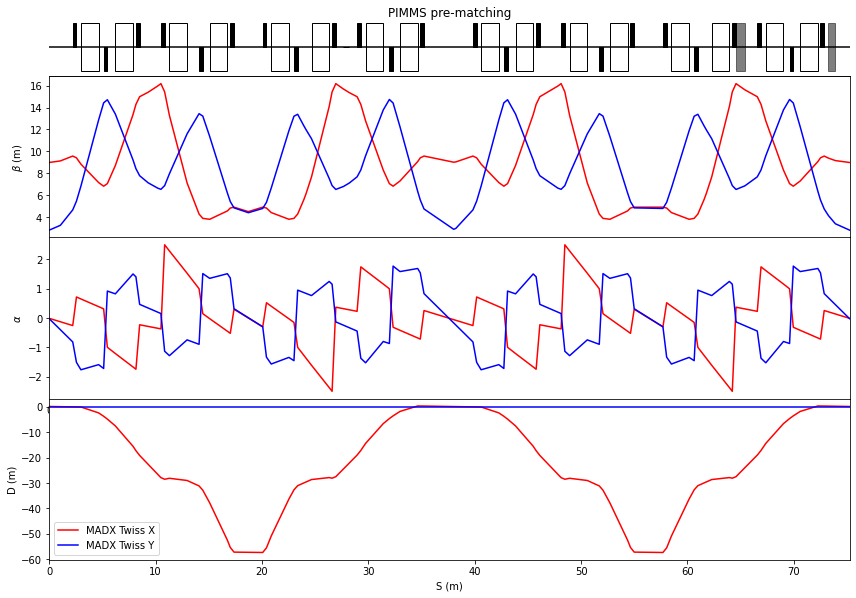

In [6]:
#Identifying the sequence
madx.use('PIMMS')
#Using the madx.twiss parameter and making it a data-frame
twiss_unmatch = madx.twiss().dframe()

#Creating a figure and using Yann's plot_twiss function
fig = plt.figure(figsize=(12,10))
plot_twiss(fig, twiss_unmatch, 'PIMMS pre-matching')

### Matching with cpymad

In [7]:
### Matching process for kickers to give injection bump

madx.use('PIMMS')
#Three families of quadrupoles
QUADS = ['QF1', 'QD', 'QF2']
KICKS = ['KCH01', 'KCH02', 'KCH03']

#Tunes of the synchrotron
#I am aware this is the wrong tune for injection, but it's an example
QH = 5/3 #1.68
QV = 1.72

with madx.batch():
    madx.command.match(sequence='PIMMS')
    
    ### CONSTRAINTS ### 
    madx.input('constraint, range=ES_injection,x=-0.0477,px=0;') #Injection septa is at 47.7mm
    madx.input('constraint, range=#s, DX=0')                     #Dispersion must be 0 at start and end of cell
    madx.input('constraint, range=#e, DX=0')                     
    madx.input('constraint, range=QD[2]/QD[7], X=0')             #Want the beam to be at position 0 throughout this range
    
    madx.input(f'GLOBAL,Q1={QH};')                               #Definine tune throughout the synchrotron
    madx.input(f'GLOBAL,Q2={QV};')
    
    ### VARIABLES ###
    for quad in QUADS:
        madx.command.vary(step=1E-3, name=f'{quad}->K1')        #For every quadrupole vary its k1
    for kick in KICKS:
        madx.command.vary(step=1E-3, name=kick)                 # Varying all three kickers
    
    #Matching method
    madx.jacobian(calls=1000, tolerance=1e-5, strategy=3)
    madx.endmatch()

START MATCHING

number of sequences: 1
sequence name: pimms
number of variables:    6
user given constraints: 1
total constraints:      67

START JACOBIAN:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   2.27529000e-01





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
qf1->k1                   3.13569e-01  3.04238e-01 -1.00000e+20  1.00000e+20
qd->k1                   -5.24788e-01 -5.20079e-01 -1.00000e+20  1.00000e+20
qf2->k1                   5.25178e-01  5.24175e-01 -1.00000e+20  1.00000e+20
kch01                     0.00000e+00  0.00000e+00 -1.00000e+20  1.00000e+20
kch02                     0.00000e+00  0.00000e+00 -1.00000e+20  1.00000e+20
kch03                     0.00000e+00  0.00

### Matched optics of PIMMS

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
             75.24                 -0       0.2553716822        1.978853445 

                q1                dq1            betxmax              dxmax 
       1.666666667        5.709556033        16.07788506        56.89850682 

             dxrms             xcomax             xcorms                 q2 
       27.38655624                  0                  0               1.72 

               dq2            betymax              dymax              dyrms 
      -20.16522111        14.73475062                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

           synch_6            

<ipython-input-5-4410825b7526>:53: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axnames.set_xlim(0, madx.eval('circum'))


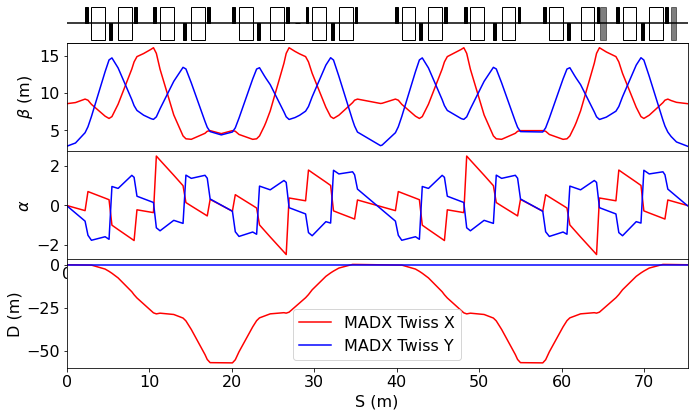

In [8]:
#Plotting Twiss again to see the effect of the matching
plt.rcParams.update({'font.size': 16, 'axes.labelsize': 16, 'axes.titlesize': 18})
twiss_match = madx.twiss().dframe()
fig = plt.figure(figsize=(10,7))
plot_twiss(fig, twiss_match, '')

### Can make your own plots with matplotlib instead of relying on plot_twiss

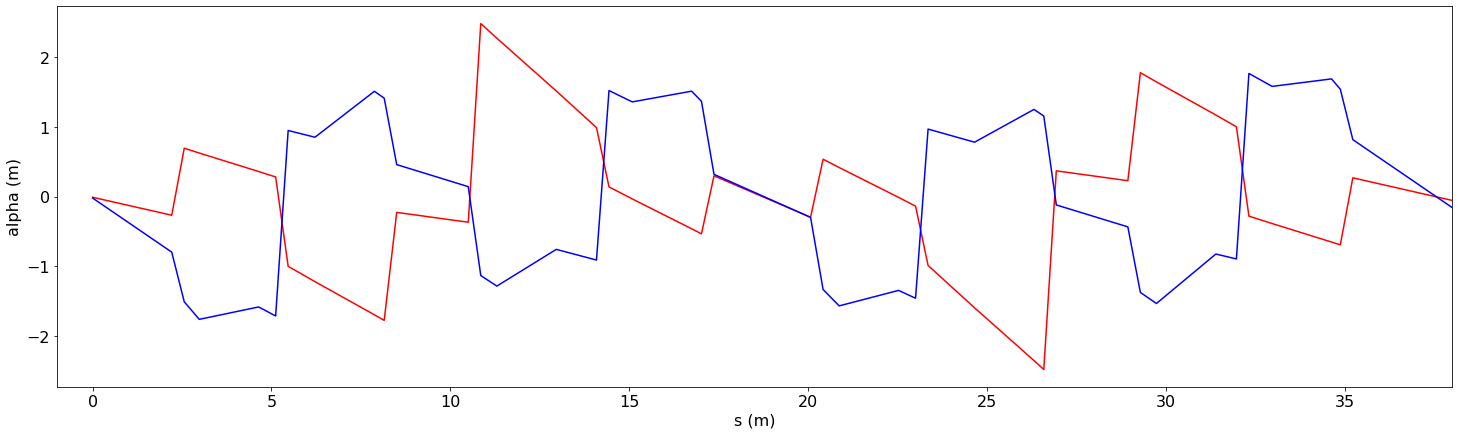

In [9]:
fig = plt.figure(figsize=(25, 7))

plt.plot(twiss_match['s'], twiss_match['alfx'], 'r-')  #x-beam position 
plt.plot(twiss_match['s'], twiss_match['alfy'], 'b-')  #y-beam position

plt.xlabel('s (m)')
plt.ylabel('alpha (m)')

plt.xlim(-1, 38)
plt.show()

### Using PTC in cpymad </p>
There is no explicit command that I am aware of, so it is all done with the madx.input function

In [10]:
#Setting up PTC environment
madx.input('''
ptc_create_universe;
ptc_create_layout,model=2,method=2,nst=5;

PTC_ALIGN;''')

#Defining one particle here
#Can do smart things like have for-loops of n particles to generate gaussian beam to match your defined Twiss parameters
x, xp, y, yp, t = 0, 0, 0, 0, 0
madx.input(f'ptc_start, x = {x}, px={xp}, y={y}, py={yp}, t={t};')

#Number of turns
N = 10

#Complete the tracking and save all particles to one file called track_PIMMS.txtone
madx.input(f'''ptc_track, turns={N}, file="track_PIMMS.txt", ONETABLE=True;
ptc_track_end;
ptc_end;''')


#If you want to have specific points, then you can track element_by_element and add
#madx.input('ptc_observe, place=XRr_point;')

  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
 JACOBIAN Strategy =           3
Initial Penalty Function =   0.2665417489296584E+01


 Solve system with            4 con,           6 var
 Rank             3   Condition number                  +Infinity
 Step length   1.29399164728282307E-002
call:     2 Dx =   0.12939916E-01  Penalty function =  0.2299091848508727E+00
 Solve system with            4 con,           6 var
 Rank             3   Condition number                  +Infinity
 Step length   9.15796070721925493E-005
call:     3 Dx =   0.91579607E-04  Penalty function =  0.2275290001408622E+00
 Solve system with            4 con,           6 var
 Rank             3   Condition number                  +Infinity
 Step length   9.11859829023067416E-009
call:     4 Dx =   0.91185983E-08  Penalty function =  0.2275290000000000E+00
 Solve system with            4 con,           

True

### Using pandas store PTC results in a dataframe

In [11]:
#Use any method you want to read the information from track_PIMMS.txtone, but this is my preferred method

#First need to clean up the data
#Reads the textfile produced from PTCtrack. Formats by removing whitespace. Removes the column labelled *, skips the header and the first two rows.
data = pd.read_csv('track_PIMMS.txtone', delim_whitespace=True, names=['Number', 'Turn', 'X', 'PX', 'Y', 'PY', 'T', 'PT', 'S', 'E'], header = 6, skiprows=2)

#Removes the line between each turn called "segment". Ensures all values are numbers not strings
data = data[data.Number != '#segment'].astype(float)
data.head()

Number  Turn    X   PX    Y   PY    T   PT      S         E
0     1.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.00  11.29467
2     1.0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  75.24  11.29467
4     1.0   2.0  0.0  0.0  0.0  0.0  0.0  0.0  75.24  11.29467
6     1.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  75.24  11.29467
8     1.0   4.0  0.0  0.0  0.0  0.0  0.0  0.0  75.24  11.29467

I believe you are familiar with pandas, so you can plot the data however you want. </p> I have single-turn and multi-turn plotting functions if you are interested

# Resonant Driving Terms

In [12]:
madx.input('''PTC_chrom_3: macro={
      ptc_create_universe;
      ptc_create_layout,model=2,method=6,nst=3, exact=true;
      select_ptc_normal, q1=0, q2=0; //fractional tune
      select_ptc_normal, dq1=1, dq2=1; // chromaticity
      select_ptc_normal, dq1=2, dq2=2; // second order chrom
      select_ptc_normal, dq1=3, dq2=3; // third order chrom

      PTC_ALIGN;
      option, -info;
      ptc_normal,deltap=dp,closed_orbit,normal,icase=5,no=4;

      !option, info;
      write, table=normal_results, file="PIMMS_nonlin.ptc";
    ptc_end;
    };

    exec, PTC_chrom_3;''')

True

In [13]:
madx.input('exec, PTC_chrom_3;')

True